In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
df = pd.read_excel('Realized Schedule 20210101-20220228.xlsx')

In [3]:
df.isna().sum()

ScheduleTime    0
Airline         0
FlightNumber    0
Destination     0
AircraftType    0
FlightType      0
Sector          0
SeatCapacity    0
LoadFactor      0
dtype: int64

In [4]:
df.head()

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301


dividing timestamp into year, day and month.

In [5]:
df['year'] = df.ScheduleTime.apply(lambda x: x.year)
df['day'] = df.ScheduleTime.apply(lambda x: x.weekday())
df['month'] = df.ScheduleTime.apply(lambda x: x.month)

Binning the hours into 4 diffreent categories. 

In [6]:
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df['time'] = pd.cut(df.ScheduleTime.dt.hour, bins,labels=labels)

Binning the Months into vinter, spring, summer and fall.

In [7]:
bins = ["Winter", "Spring", "Summer", "Fall"]
df['Season'] = df.month%12 //3
df['Season'] = df['Season'].apply(lambda x : bins[x])

Dummy on sector, flighttype, time and Season

In [8]:
df=pd.get_dummies(df,columns=['Sector','FlightType','time', 'Season'],drop_first=True)

Cleaning a bit

In [9]:
df = df.drop(['ScheduleTime', 'month'], axis=1)

In [10]:
df

,Airline,FlightNumber,Destination,AircraftType,SeatCapacity,LoadFactor,year,day,Sector_CA,Sector_CN,...,Sector_SG,Sector_US,FlightType_G,FlightType_J,time_morning,time_daytime,time_afternoon,Season_Spring,Season_Summer,Season_Winter
0,IA,874,DEN,73W,142,0.408451,2021,4,0,0,...,0,1,0,1,0,0,0,0,0,1
1,JZ,818,YHM,AT7,74,0.189189,2021,4,1,0,...,0,0,0,1,1,0,0,0,0,1
2,IA,876,DEN,73W,142,0.570423,2021,4,0,0,...,0,1,0,1,1,0,0,0,0,1
3,CN,514,EST,AT7,72,0.333333,2021,4,0,0,...,0,1,0,1,0,1,0,0,0,1
4,LJ,3140,DEN,32A,186,0.204301,2021,4,0,0,...,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,VW,986,YYZ,319,144,0.847222,2022,0,1,0,...,0,0,0,1,0,1,0,0,0,1
39445,LJ,667,YDQ,319,156,0.871795,2022,0,1,0,...,0,0,0,1,0,0,1,0,0,1
39446,VW,3406,MYV,E90,98,0.857143,2022,0,0,0,...,0,1,0,1,0,0,1,0,0,1
39447,LJ,663,RUT,32N,186,0.682796,2022,0,0,0,...,0,1,0,1,0,0,1,0,0,1


Doing frequency encoding of destination adn airline

In [11]:
fe_ = df.groupby("Destination").size()/len(df)
df['freq_destination'] = df["Destination"].map(fe_).round(4)

fe_ = df.groupby("Airline").size()/len(df)
df['freq_airline'] = df["Airline"].map(fe_).round(3)

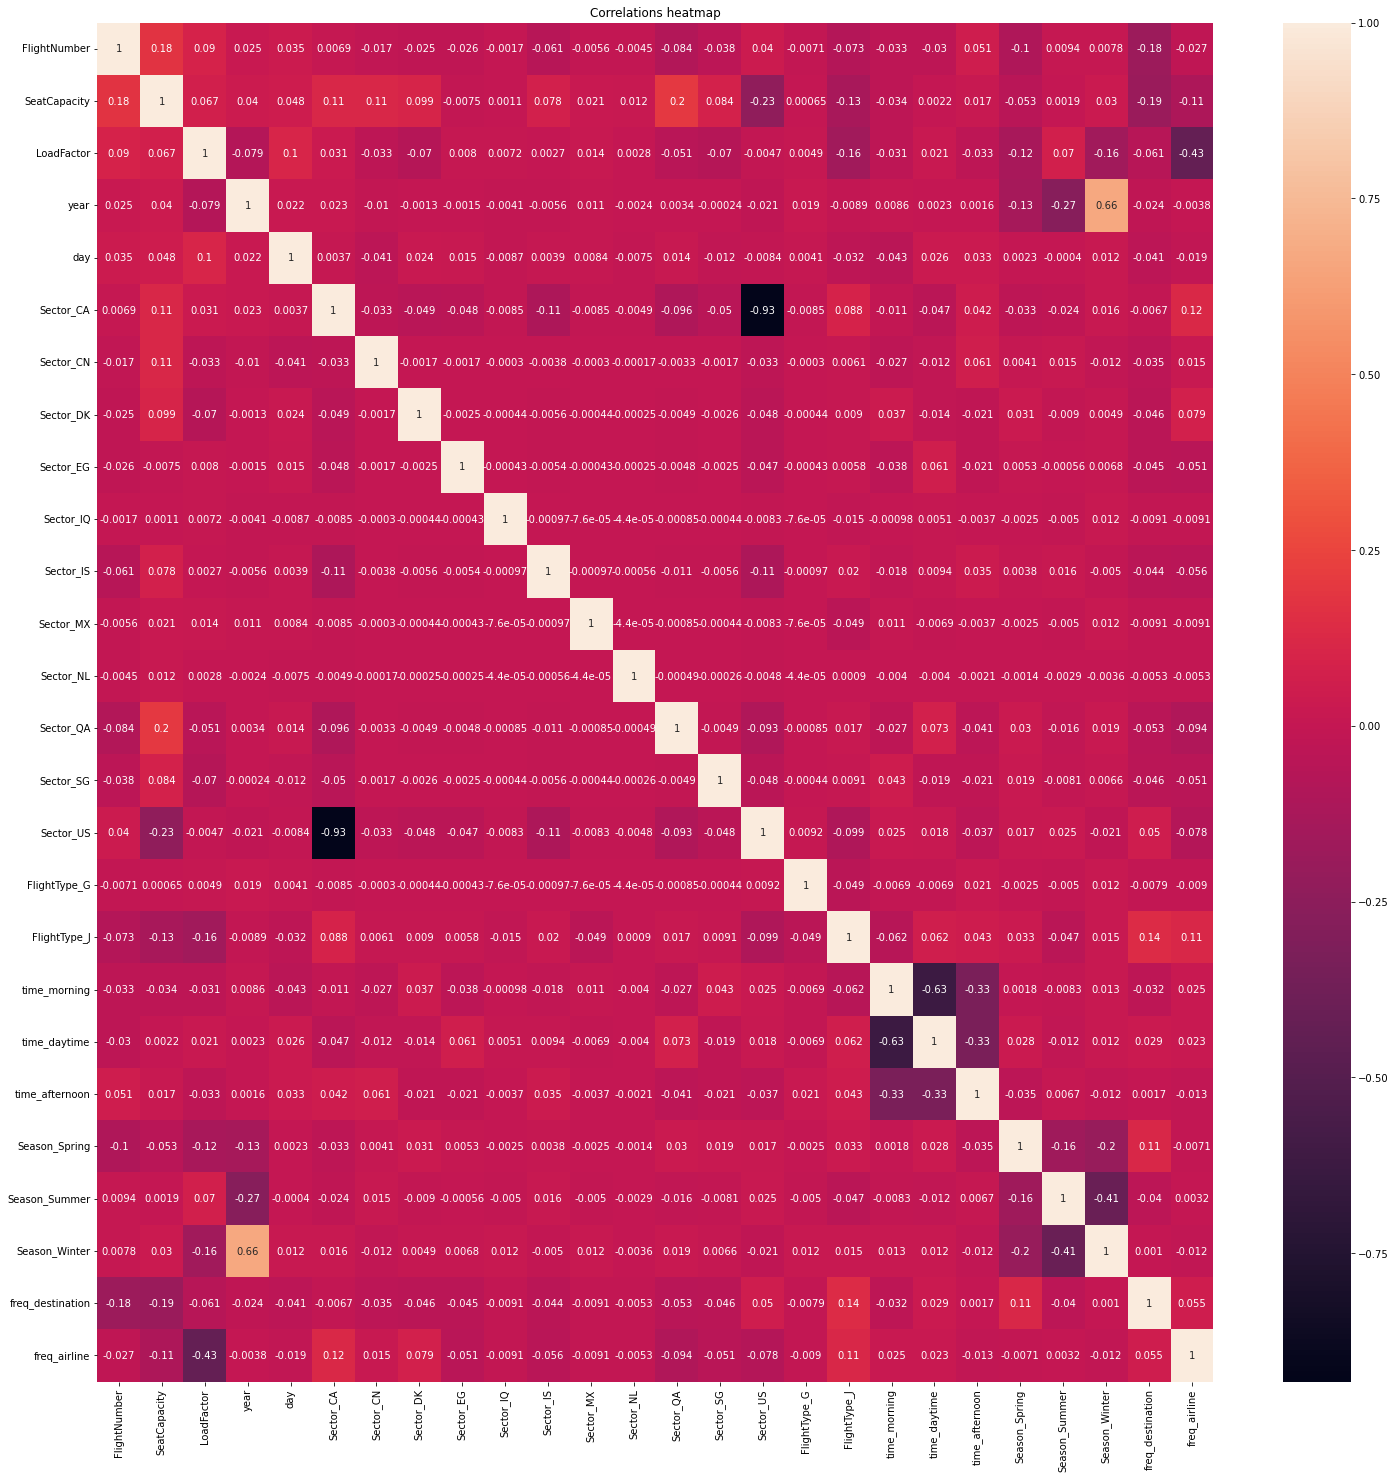

In [12]:
corr=df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
plt.title("Correlations heatmap")
plt.show()

In [13]:
df.head()

,Airline,FlightNumber,Destination,AircraftType,SeatCapacity,LoadFactor,year,day,Sector_CA,Sector_CN,...,FlightType_G,FlightType_J,time_morning,time_daytime,time_afternoon,Season_Spring,Season_Summer,Season_Winter,freq_destination,freq_airline
0,IA,874,DEN,73W,142,0.408451,2021,4,0,0,...,0,1,0,0,0,0,0,1,0.0460,0.035
1,JZ,818,YHM,AT7,74,0.189189,2021,4,1,0,...,0,1,1,0,0,0,0,1,0.0163,0.012
2,IA,876,DEN,73W,142,0.570423,2021,4,0,0,...,0,1,1,0,0,0,0,1,0.0460,0.035
3,CN,514,EST,AT7,72,0.333333,2021,4,0,0,...,0,1,0,1,0,0,0,1,0.0315,0.064
4,LJ,3140,DEN,32A,186,0.204301,2021,4,0,0,...,0,1,0,1,0,0,0,1,0.0460,0.091


In [14]:
X = df.loc[:, df.columns != 'LoadFactor']
y = df['LoadFactor']
N, P = X.shape

In [15]:
X = X.drop(['Airline', 'FlightNumber', 'Destination', 'AircraftType'], axis=1)

In [16]:
# Try to experiment with max_samples, max_features, number of modles, and other models
n_estimators = range(5,101)
max_depth = range(1,11)
rng = np.random.RandomState(1)
#We do an outer loop over max_depth here ourselves because we cannot include in the CV paramgrid.
#Notice this is not a "proper" way to select the best max_depth but for the purpose of vizuallizing behaviour it should do
test_acc = np.zeros((len(n_estimators), len(max_depth)))
for i in max_depth:
    
    # Create and fit an AdaBoosted decision tree
    boost =  AdaBoostRegressor(DecisionTreeRegressor(max_depth=i), random_state=rng)
    
    param_grid = {
        'n_estimators': n_estimators
    }
    
    boost_grid = GridSearchCV(estimator = boost, param_grid = param_grid,verbose = 2)

    # Fit the grid search model
    boost_grid.fit(X, y)

    test_acc[:,i-1] = boost_grid.cv_results_['mean_test_score']

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=6; total time=   0.0s
[CV] END .....................................n_estimators=6; total time=   0.1s
[CV] END .....................................n_estimators=6; total time=   0.1s
[CV] END .....................................n_estimators=6; total time=   0.0s
[CV] END .....................................n_estimators=6; total time=   0.0s
[CV] END .....................................n_estimators=7; total time=   0.1s
[CV] END .....................................n

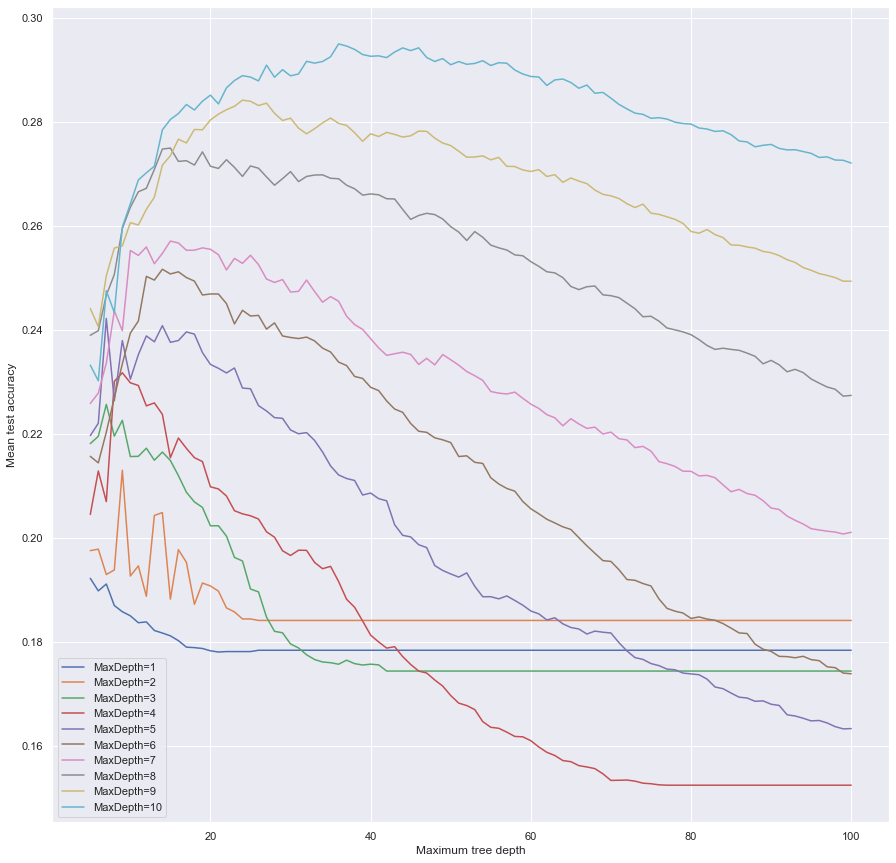

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(n_estimators, test_acc)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
ax.legend(['MaxDepth=1','MaxDepth=2','MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])